In [1]:
# numpy and scipy
import numpy as np
import scipy.stats as stt
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio


# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd

#saving results
import os

In [4]:
data_dir = './' # data repo
res_dir = './recovery/' # results
os.makedirs(res_dir, exist_ok=True)
graph_format = 'png' # graph formatting


# data and model parameters
n_sub = 47
#Change
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

N = 68 # size of network for AAL90

In [5]:
# load empirical data
TS_CTR  = np.load('./TS_Control.npy')
TS_SCZ  = np.load('./TS_Schizo.npy')

In [6]:
# Original array separated by conditions

# Example input array of shape (180, 718, 36)
# original_array = TS

# Separate the participants by condition
condition_0 = TS_CTR[0:48, 0:68, :]  # all participants (condition 0)
condition_1 = TS_SCZ[:, 0:68, :]  # Last 48 participants (condition 1)

# Determine the maximum number of participants in either condition (for alignment)
max_participants = max(condition_0.shape[2], condition_1.shape[2])

# Pad the smaller group to match the size of the larger one along the participant dimension
condition_0_padded = np.pad(condition_0, ((0, 0), (0, 0), (0, max_participants - condition_0.shape[2])), mode='constant')
condition_1_padded = np.pad(condition_1, ((0, 0), (0, 0), (0, max_participants - condition_1.shape[2])), mode='constant')

# Stack the conditions along the fourth dimension
new_array_original = np.stack((condition_0_padded, condition_1_padded), axis=3)

print("New array shape:", new_array_original.shape)


New array shape: (48, 68, 152, 2)


In [7]:
# Array with removed indexes

# Define indices to remove
indices_to_remove = {0: 19, 1: 11}

# Use list comprehension to filter out the indices for each condition
new_array = np.stack([
    new_array_original[np.arange(48) != indices_to_remove[0], :, :, 0],  # Remove index 19 for condition 0
    new_array_original[np.arange(48) != indices_to_remove[1], :, :, 1]   # Remove index 11 for condition 1
], axis=-1)

print(new_array.shape)  # Should be (47, 68, 152, 2)

(47, 68, 152, 2)


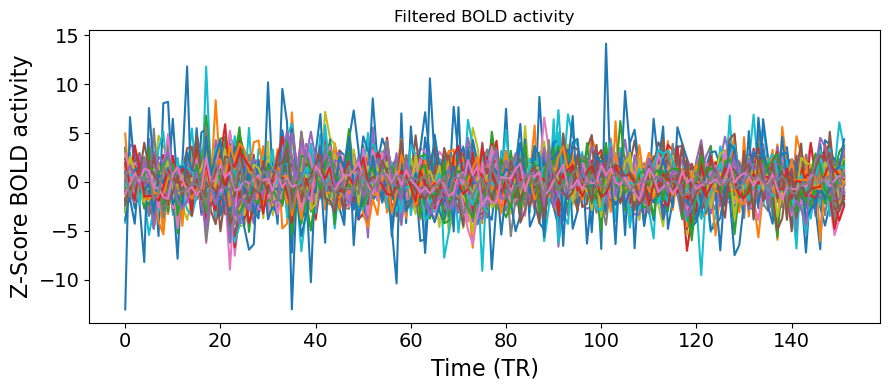

In [8]:
# Plot of BOLD signals stored in new_array 

plt.figure(figsize=(9,4))
plt.plot(range(new_array.shape[2]), new_array[1,:,:,1].T)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (TR)', fontsize=16)
plt.ylabel('Z-Score BOLD activity', fontsize=16)
plt.title("Filtered BOLD activity")
plt.tight_layout()

## Create Masks

- Topological mask

network size: 68
EC density: 0.017120280948200176


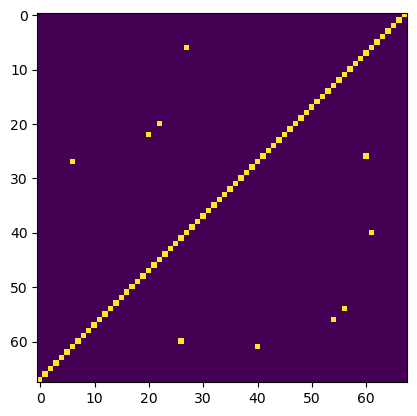

In [41]:
# create topological mask for AAL90

SCR = sio.loadmat('./SC_EnigmadK68.mat')['matrix']
SC=SCR/np.max(SCR)
lim_SC = 0.9 # limit DTI value to determine SC (only connections with larger values are tuned)
# anatomy-derived mask for existing connections for EC
mask_ECS = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_ECS[SC>lim_SC] = True
for i in range(N):
    mask_ECS[i,i] = False # no self connection
    mask_ECS[i,N-1-i] = True # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_ECS.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0

plt.imshow(mask_ECS)


- Functional mask

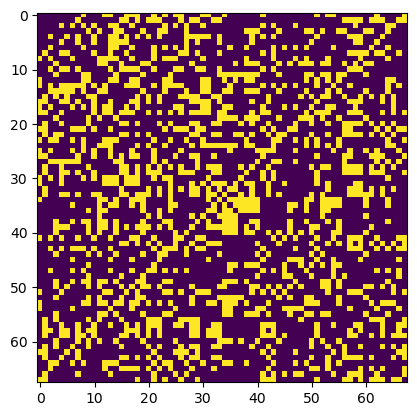

In [42]:
# limits for the functional mask: 

lim_FC = np.full((48, 2), 0.1)

'''
#outliers
lim_FC[11, 1] = 0.05
lim_FC[19, 0] = 0.05
'''

#good changes
lim_FC[23, 1] = 0.2
lim_FC[18, 1] = 0.2
lim_FC[45, 0] = 0.2
lim_FC[11, 0] = 0.3
lim_FC[45, 0] = 0.3
lim_FC[45, 1] = 0.2

'''
EPR is high: [15, 1]
EPR is high: [24, 1]
'''
lim_FC[15, 1] = 0.1
lim_FC[24, 1] = 0.1


# array to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance

# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time series
        ts = new_array[i_sub,:,:,i_cond]
        # store empirical BOLD variance (48, 68, 152, 2)
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
        FC0 = np.corrcoef(new_array[i_sub,:,:,i_cond]) 
        FC1 = FC0/np.max(FC0)
        mask_ECF = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_ECF[FC1>lim_FC[i_sub, i_cond]] = True
        for i in range(N):
            mask_ECF[i,i] = False # no self connection
            mask_ECF[i,N-1-i] = True # additional interhemispherical connections

plt.imshow(mask_ECF)

In [43]:
mask_ECF.dtype

dtype('bool')

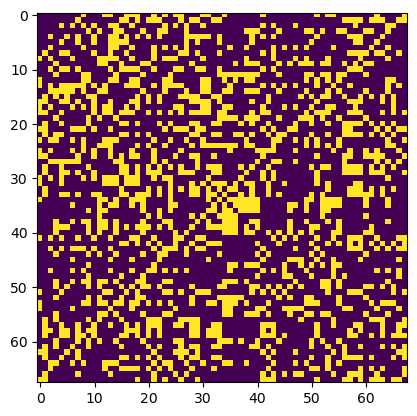

In [44]:
# Logical OR between the two masks: 

mask_EC = np.logical_or(mask_ECS, mask_ECF).astype(bool)
plt.imshow(mask_EC)

## Fit the model

In [45]:
# Fitting MOU

#using new_array where all data are stored: 

min_val_EC = 0. # minimal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

# arrays to store results
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC.) In the article of Entropy production B=-J
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model sigma. In the article of Entropy production sigma=2D
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)

# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        
        ts = new_array[i_sub,:,:,i_cond]

         # invert model
        mou_est = MOUv2()
        mou_est.fit(ts.T, mask_C=mask_EC, mask_Sigma=mask_Sigma, algo_version='true', min_iter=20, epsilon_C=0.005, epsilon_Sigma=0.005) #, verbose=True)

        # store results
        J_mod[i_sub,i_cond,:,:] = mou_est.J
        Sigma_mod[i_sub,i_cond,:,:] = mou_est.Sigma
        FC0_mod[i_sub,i_cond,:,:] = spl.solve_lyapunov(J_mod[i_sub,i_cond,:,:].T, -Sigma_mod[i_sub,i_cond,:,:])
        err_mod[i_sub,i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub,i_cond] = mou_est.d_fit['correlation']

        print('sub', i_sub, '; cond', i_cond, ':', mou_est.d_fit)


sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 117, 'distance': np.float64(0.7803523280510511), 'correlation': np.float64(0.7102071682406734), 'distance history': array([0.91027644, 0.90825991, 0.90627839, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.42523869, 0.43196521, 0.43855286, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.7405814088153579), 'distFC1': np.float64(0.8201261281436948)}
sub 0 ; cond 1 : {'n_tau': 2, 'iterations': 30, 'distance': np.float64(0.8499210558118249), 'correlation': np.float64(0.5644762664931962), 'distance history': array([0.89350402, 0.89045283, 0.88779803, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.40505704, 0.4257573 , 0.44467419, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.7412183460282349), 'distFC1': np.float64(0.9590092271249135)}
sub 1 ; cond 0 : {'n_tau': 2, 'iterations': 104, 'distance': np.float64(0.8283849794373468)

In [46]:
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        if fit_mod[i_sub,i_cond]< 0.55:
            print(i_sub, i_cond)

1 1
8 0
11 0
15 1
20 1
22 1
23 0
23 1
45 0
45 1


In [47]:
#%% save results
np.save(os.path.join(res_dir, f'J_mod_try.npy'), J_mod)
np.save(os.path.join(res_dir, f'Sigma_mod_try.npy'), Sigma_mod)
np.save(os.path.join(res_dir, f'FC0_mod_try.npy'), FC0_mod)

np.save(os.path.join(res_dir, f'err_mod_try.npy'), err_mod)
np.save(os.path.join(res_dir, f'fit_mod_try.npy'), fit_mod)

np.save(os.path.join(res_dir, f'var_BOLD_try.npy'), var_BOLD)


/tmp/ipykernel_10908/1680162601.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_10908/1680162601.py:15: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_10908/1680162601.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_10908/1680162601.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)


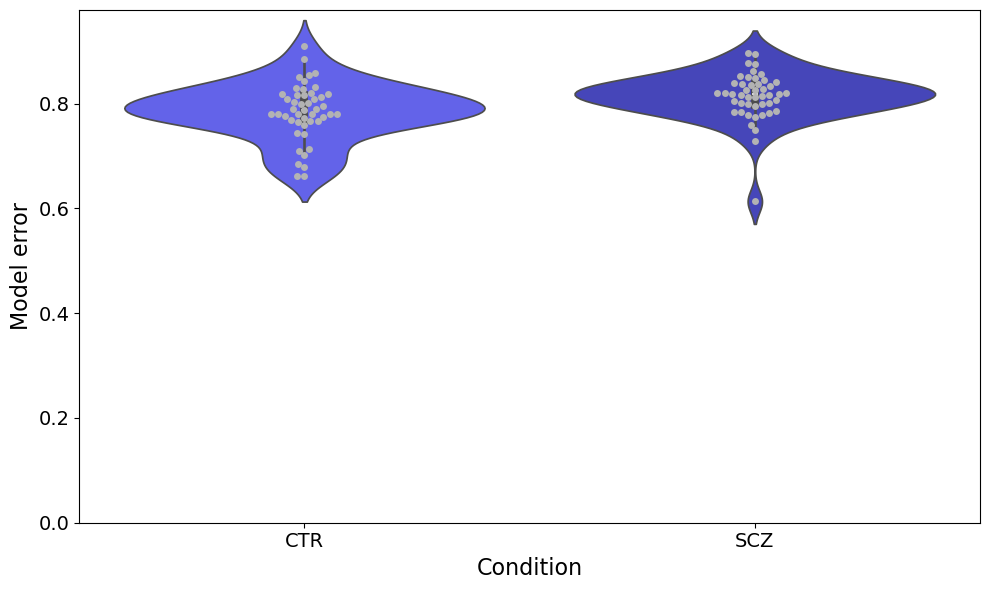

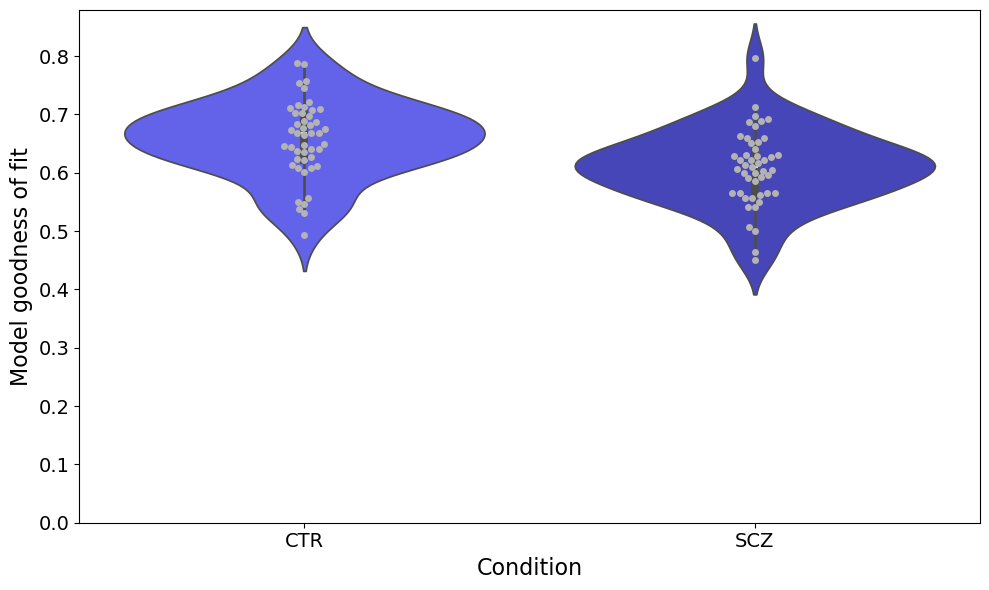

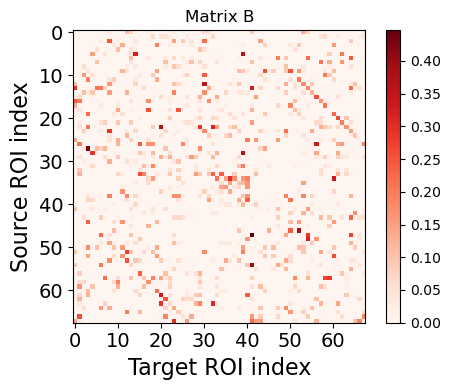

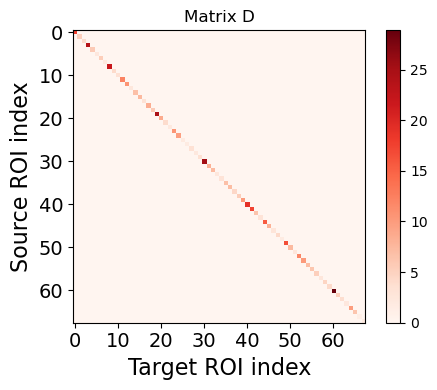

In [48]:
mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

# model error

err_mod_tmp = dict()
err_mod_tmp['sum EC'] = err_mod.flatten()
err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

err_mod_df = pd.DataFrame(err_mod_tmp)
# Create the figure
plt.figure(figsize=(10, 6))
sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model error',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_fit_error_try.eps'), format='eps')

# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)


# Create the figure
plt.figure(figsize=(10, 6))
sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model goodness of fit',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_goodness_fit_try.eps'), format='eps')


# Example EC

plt.figure(figsize=(5,4))
plt.imshow(np.maximum(J_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
#plt.imshow(J_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix B')
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example0_EC_try.eps'), format='eps')#Change

# Example EC

plt.figure(figsize=(5,4))
#plt.imshow(np.maximum(Sigma_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
plt.imshow(Sigma_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix D')
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example_EC_try.eps'), format='eps')

# 


In [ ]:
# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)
